In [1]:
## Project title: Predicting Obesity using machine learning models

######################################################################################
# 1. Load the necessary packages
######################################################################################

# Data processing
import pandas as pd
import numpy as np
import random as rn
from pandas.api.types import CategoricalDtype

# Standardize the data
from sklearn.preprocessing import StandardScaler

# Modeling 
import tensorflow as tf
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE   ## to help with extreme imbalances in outcome variables for classification models.
from sklearn.linear_model import LogisticRegression                        ## For Logistic regression
from sklearn.linear_model import LogisticRegressionCV                      ## For Logistic regression CV
from sklearn.ensemble import GradientBoostingClassifier                    ## for GB classification
from sklearn.tree import DecisionTreeClassifier                            ## for DT classification
from sklearn.ensemble import RandomForestClassifier                        ## for RF classification
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV            ## for regularization
from sklearn.linear_model import lasso_path                                ## for lasso coef path
from sklearn.svm import SVC                                                ## for support vector classification
from sklearn.preprocessing import label_binarize

# Hyperparameter tuning
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score

# Plot
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay    ## For confusipn matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Model evaluation
from sklearn.metrics import roc_curve, classification_report, confusion_matrix, auc, roc_auc_score, accuracy_score ## for classification
from sklearn import metrics

In [3]:
dat = pd.read_csv('ObesityDataset_raw_and_data_sinthetic.csv')
print(dat.columns)
print(dat.shape)
dat['NObeyesdad'].value_counts() # The main study indicated that they used SMOTE to correct the imbalances.

## ommiting heigh and weight since they were used to compute the outcome variable
dat = dat.drop(['Height', 'Weight'], axis = 1)
print(dat.columns)

## checking categorical predictors
categorical_vars = ['Gender','family_history_with_overweight','FAVC', 'FCVC', 'NCP', 
                    'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS']     

#for col in categorical_vars:
#   print(f'\nrequencies of the distinct values of {col}:\n')
#   print(dat[col].value_counts(dropna=False)) 

## The category "Always" under the "CALC" variable has only one observation, so I ma adding it to "Frequently"
dat['CALC'] = dat['CALC'].replace({'Always': 'Frequent', 'Frequently': 'Frequent'})

## Combine Bike and Motorbike under the variable 'MTRANS' call it'Motor'
dat['MTRANS'] = dat['MTRANS'].replace({'Bike': 'Motor', 'Motorbike': 'Motor'})

## Final continuous variables
continuous_vars = ['Age','FCVC','CH2O','FAF', 'NCP', 'TUE'] 
print(dat[continuous_vars].describe())

## Final categorical variables
final_categorical_vars = ['Gender','family_history_with_overweight','FAVC',  
                    'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']  

## One-hot encoding of the categorical variables ##

# Convert specified variables to 'category' dtype (optional but good practice)
dat[final_categorical_vars] = dat[final_categorical_vars].astype('category')

# One-hot encode the categorical variables
encoded_cats = pd.get_dummies(dat[final_categorical_vars], drop_first=True)  # drop_first to avoid dummy trap

# View the result
print(encoded_cats.head())

# Combine with the rest of the dataset if needed
dat_encoded = pd.concat([dat.drop(columns=final_categorical_vars), encoded_cats], axis=1)
print(dat_encoded.columns)



Index(['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight',
       'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE',
       'CALC', 'MTRANS', 'NObeyesdad'],
      dtype='object')
(2111, 17)
Index(['Gender', 'Age', 'family_history_with_overweight', 'FAVC', 'FCVC',
       'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS',
       'NObeyesdad'],
      dtype='object')
               Age         FCVC         CH2O          FAF          NCP  \
count  2111.000000  2111.000000  2111.000000  2111.000000  2111.000000   
mean     24.312600     2.419043     2.008011     1.010298     2.685628   
std       6.345968     0.533927     0.612953     0.850592     0.778039   
min      14.000000     1.000000     1.000000     0.000000     1.000000   
25%      19.947192     2.000000     1.584812     0.124505     2.658738   
50%      22.777890     2.385502     2.000000     1.000000     3.000000   
75%      26.000000     3.000000     2.477420     1.666678  

In [5]:
######################################################################################
# 4. Data split and standardization for the continuous outcome
######################################################################################
# seed for reproducibility
seed = 999

## The below is necessary for starting Numpy generated random numbers
## in a well-defined initial state.
np.random.seed(seed)

# Train (80%) and test (20%) set split (For the contregress)
# Make separate data set for Y and X
Y_bin = dat_encoded['NObeyesdad']
X_bin = dat_encoded.drop(['NObeyesdad'], axis=1)

print(f'The dependent (Y) dataset has {Y_bin.shape}.')
print(f'The independent (X) dataset has {X_bin.shape}.')

# Splitting the dataset into train and test sets
X_train, X_test, y_train, y_test  = train_test_split( X_bin, Y_bin, test_size = 0.2, random_state = 42)

print(f'The training dataset has {len(X_train)} observations')
print(f'The test dataset has {len(X_test)} observations')

# Standardization of continuous variable.
# VERY IMPORTANT: To avoid any information leaking from testing data to training data, we do standardization separately. 
# define continuous variable columns
final_cont_vars = ['Age','FCVC','CH2O','FAF', 'NCP', 'TUE']
scaler = StandardScaler()
X_train[continuous_vars] = scaler.fit_transform(X_train[continuous_vars])
X_test[continuous_vars] = scaler.fit_transform(X_test[continuous_vars])
print(X_train[continuous_vars].describe())
print(X_test[continuous_vars].describe())


## checking the dimension of data
print(f'The training dataset has {X_train.shape}')
print(f'The test dataset has {X_test.shape}')


The dependent (Y) dataset has (2111,).
The independent (X) dataset has (2111, 19).
The training dataset has 1688 observations
The test dataset has 423 observations
                Age          FCVC          CH2O           FAF           NCP  \
count  1.688000e+03  1.688000e+03  1.688000e+03  1.688000e+03  1.688000e+03   
mean   6.061502e-16  3.451689e-16  3.809486e-16  1.325954e-16  8.292472e-16   
std    1.000296e+00  1.000296e+00  1.000296e+00  1.000296e+00  1.000296e+00   
min   -1.613697e+00 -2.648174e+00 -1.651053e+00 -1.196238e+00 -2.154968e+00   
25%   -6.872925e-01 -7.857288e-01 -6.799109e-01 -1.038621e+00 -3.487999e-02   
50%   -2.466699e-01 -5.486419e-02 -1.014187e-02 -5.012253e-03  4.015128e-01   
75%    2.395332e-01  1.076717e+00  7.416657e-01  7.649598e-01  4.015128e-01   
max    5.644787e+00  1.076717e+00  1.630769e+00  2.377438e+00  1.679753e+00   

                TUE  
count  1.688000e+03  
mean  -1.010250e-16  
std    1.000296e+00  
min   -1.069472e+00  
25%   -1.06947

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


The Accuracy is 0.62

Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.59      0.77      0.67        56
      Normal_Weight       0.50      0.27      0.35        62
     Obesity_Type_I       0.62      0.60      0.61        78
    Obesity_Type_II       0.59      0.86      0.70        58
   Obesity_Type_III       0.84      1.00      0.91        63
 Overweight_Level_I       0.56      0.48      0.52        56
Overweight_Level_II       0.44      0.28      0.34        50

           accuracy                           0.62       423
          macro avg       0.59      0.61      0.59       423
       weighted avg       0.60      0.62      0.59       423



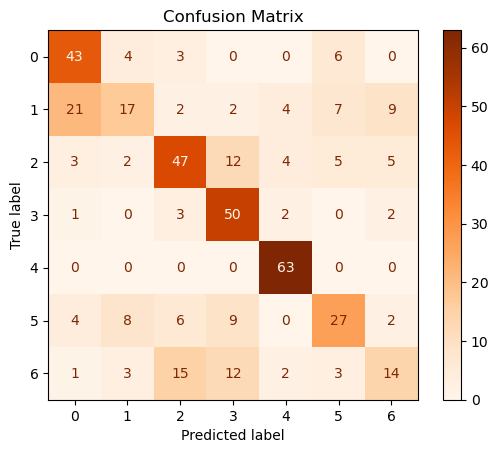

In [7]:
######################################################################################
# 5. Model building (logistic regression)
######################################################################################
# creating new datasets for the logistic model
x_test_mult = X_test
y_test_mult = y_test
x_train_mult = X_train
y_train_mult = y_train


# Define the logistic regression model
multi_mod = LogisticRegression(max_iter=10000,
                                penalty = 'none',
                                multi_class='multinomial',
                                random_state = 42,
                                solver = 'lbfgs')

# Fit the model
multi_mod.fit(x_train_mult, y_train_mult)

######################################################################################
# evaluating the model
######################################################################################
# predicted class
y_pred_mult = multi_mod.predict(x_test_mult) ## predicted class

## Accuracy
accuracy_mult = accuracy_score(y_test_mult, y_pred_mult)
print(f'The Accuracy is {accuracy_mult:.2f}')

# Calculate the confusion matrix
cm_mult = confusion_matrix(y_test_mult, y_pred_mult)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test_mult, y_pred_mult))

## Confusion matrix
conf_mult = ConfusionMatrixDisplay(confusion_matrix=cm_mult)
conf_mult.plot(cmap=plt.cm.Oranges)
plt.title("Confusion Matrix")
plt.show()


Accuracy: 0.68


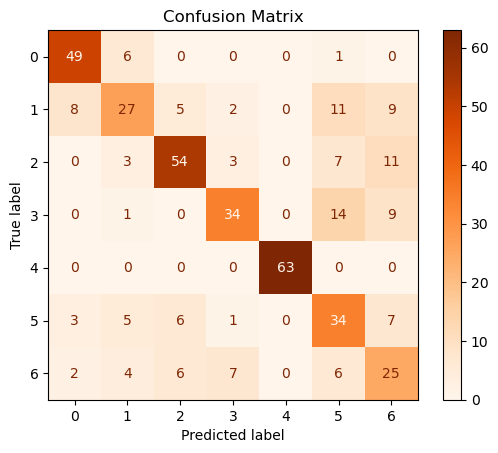


Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.79      0.88      0.83        56
      Normal_Weight       0.59      0.44      0.50        62
     Obesity_Type_I       0.76      0.69      0.72        78
    Obesity_Type_II       0.72      0.59      0.65        58
   Obesity_Type_III       1.00      1.00      1.00        63
 Overweight_Level_I       0.47      0.61      0.53        56
Overweight_Level_II       0.41      0.50      0.45        50

           accuracy                           0.68       423
          macro avg       0.68      0.67      0.67       423
       weighted avg       0.69      0.68      0.68       423



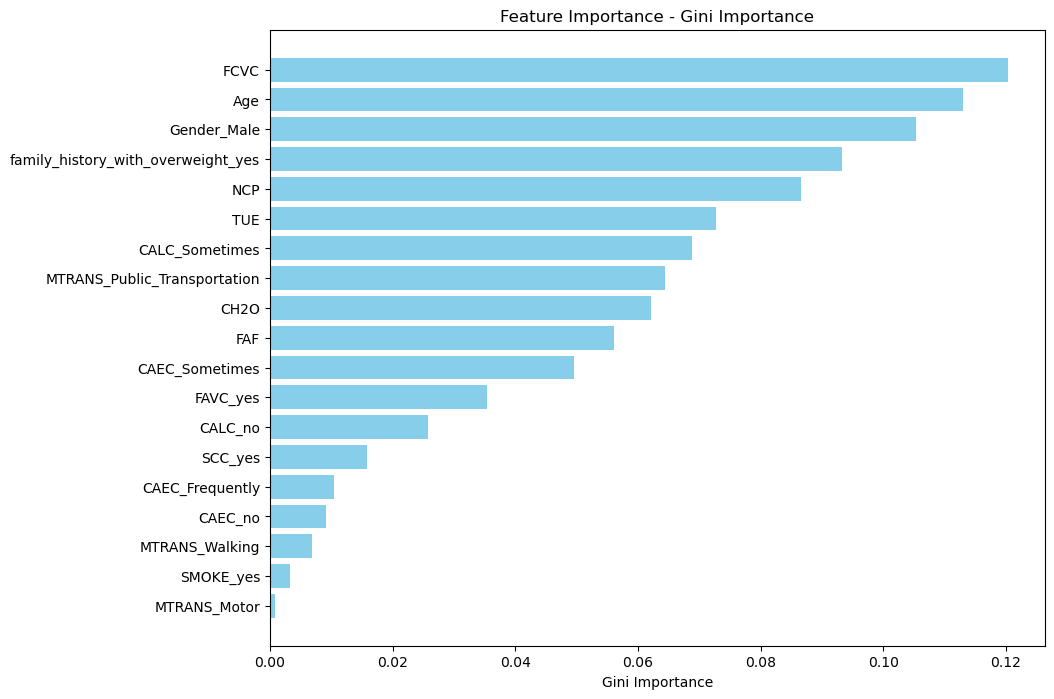

In [9]:
######################################################################################
# Decision tree classifier
######################################################################################
# creating new datasets for this analysis
x_test_dt = X_test
y_test_dt = y_test
x_train_dt = X_train
y_train_dt = y_train

# The DT classifier
dt = DecisionTreeClassifier()

# Hyperparameter search for GB.
dt_param_grid = {
    'criterion':  ['gini', 'entropy'],
    'max_depth':  [None, 2, 4, 6, 8, 10, 20, 30, 50, 100],
    'max_features': [None, 'sqrt', 'log2', 0.2, 0.4, 0.6, 0.8],
    'splitter': ['best', 'random']
    }

# Instantiate the grid search model
# change verbose to any interger if you want to print out the message
dt_grid_search = GridSearchCV(estimator=dt, param_grid=dt_param_grid, n_jobs = -1, cv = 10, verbose=False)

# Train the model
dt_grid_search.fit(x_train_dt, y_train_dt)

dt_best_grid = dt_grid_search.best_estimator_
dt_best_params = dt_grid_search.best_params_

######################################################################################
# Model evaluation and plotting
######################################################################################

## predicted classes (binary. 0 and 1)
y_hat_dt = dt_best_grid.predict(x_test_dt)  

# Calculate the confusion matrix
cm_dt = confusion_matrix(y_test_dt, y_hat_dt)

# Calculate accuracy
accuracy_dt = accuracy_score(y_test_dt, y_hat_dt)

# Print Accuracy
print(f"Accuracy: {accuracy_dt:.2f}") 

## Confusion matrix
conf_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt)
conf_dt.plot(cmap=plt.cm.Oranges)
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test_dt, y_hat_dt))


# Let's get variable importance
## Getting feature names from training data
feature_names_dt = x_test_dt.columns  

## Get feature importances
importances_dt = dt_best_grid.feature_importances_

## Create a DataFrame for display
feature_imp_dt = pd.DataFrame({
    'Feature': feature_names_dt,
    'Gini Importance': importances_dt
}).sort_values('Gini Importance', ascending=False)
#print(feature_imp_dt)

## Plot the feature importances
plt.figure(figsize=(10, 8))
plt.barh(feature_imp_dt['Feature'], feature_imp_dt['Gini Importance'], color='skyblue')
plt.xlabel('Gini Importance')
plt.title('Feature Importance - Gini Importance')
plt.gca().invert_yaxis()
plt.show()

Accuracy: 0.81


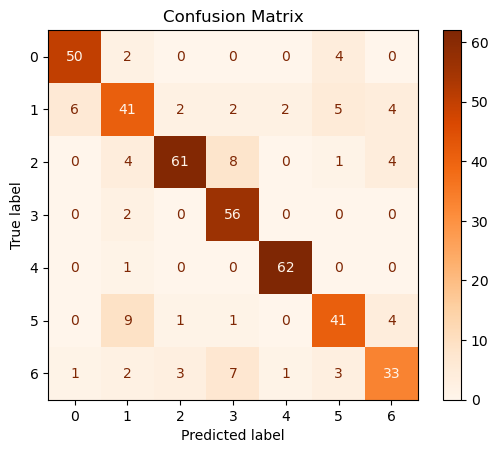


Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.88      0.89      0.88        56
      Normal_Weight       0.67      0.66      0.67        62
     Obesity_Type_I       0.91      0.78      0.84        78
    Obesity_Type_II       0.76      0.97      0.85        58
   Obesity_Type_III       0.95      0.98      0.97        63
 Overweight_Level_I       0.76      0.73      0.75        56
Overweight_Level_II       0.73      0.66      0.69        50

           accuracy                           0.81       423
          macro avg       0.81      0.81      0.81       423
       weighted avg       0.82      0.81      0.81       423



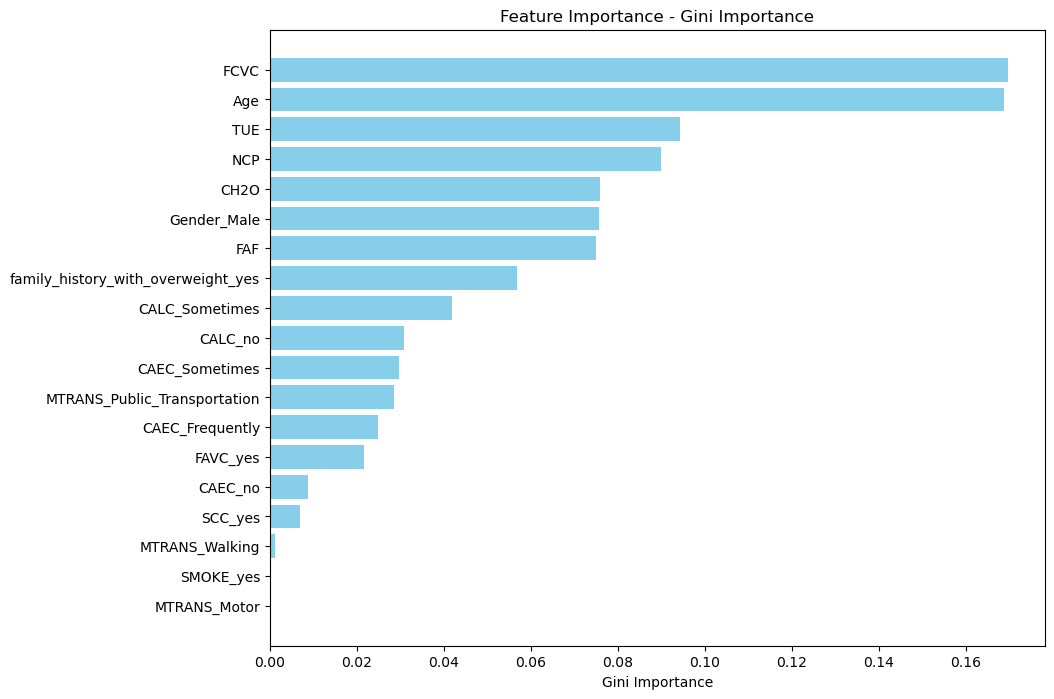

In [11]:
######################################################################################
# 4. Random forest
######################################################################################
# creating new datasets for this analysis
x_test_rf = X_test
y_test_rf = y_test
x_train_rf = X_train
y_train_rf = y_train

rf = RandomForestClassifier()

# Hyperparameter search (tunning) for RF.
rf_param_grid = {
    'max_depth': [20, 30],
    'max_features': [2, 3, 4, 5, 8,10], 
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [3, 4, 5],
    'n_estimators': [100, 200, 300]  
    }    

# Instantiate the grid search model
rf_grid_search = GridSearchCV (estimator = rf, param_grid = rf_param_grid, cv = 5, n_jobs = -1, verbose = False)

# Train the model
rf_grid_search.fit(x_train_rf, y_train_rf)


# Get the best model and its corresponding hyperparameters
rf_best_grid = rf_grid_search.best_estimator_
rf_best_params = rf_grid_search.best_params_


######################################################################################
# Model evaluation
######################################################################################
# predicted class
y_hat_rf = rf_best_grid.predict(x_test_rf)

# Calculate the confusion matrix
cm_rf = confusion_matrix(y_test_rf, y_hat_rf)

# Calculate accuracy
accuracy_rf = accuracy_score (y_hat_rf, y_test_rf)
print(f"Accuracy: {accuracy_rf:.2f}")

## Confusion matrix
conf_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
conf_rf.plot(cmap=plt.cm.Oranges)
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test_rf, y_hat_rf))

## Let's get variable importance
## Getting feature names from training data
feature_names_rf = x_test_rf.columns  

## Get feature importances
importances_rf = rf_best_grid.feature_importances_

## Create a DataFrame for display
feature_imp_rf = pd.DataFrame({
    'Feature': feature_names_rf,
    'Gini Importance': importances_rf
}).sort_values('Gini Importance', ascending=False)
#print(feature_imp_df)

## Plot the feature importances
plt.figure(figsize=(10, 8))
plt.barh(feature_imp_rf['Feature'], feature_imp_rf['Gini Importance'], color='skyblue')
plt.xlabel('Gini Importance')
plt.title('Feature Importance - Gini Importance')
plt.gca().invert_yaxis()
plt.show()

Accuracy: 0.76

Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.74      0.89      0.81        56
      Normal_Weight       0.77      0.32      0.45        62
     Obesity_Type_I       0.84      0.68      0.75        78
    Obesity_Type_II       0.74      0.97      0.84        58
   Obesity_Type_III       0.95      1.00      0.98        63
 Overweight_Level_I       0.68      0.75      0.71        56
Overweight_Level_II       0.58      0.72      0.64        50

           accuracy                           0.76       423
          macro avg       0.76      0.76      0.74       423
       weighted avg       0.77      0.76      0.74       423



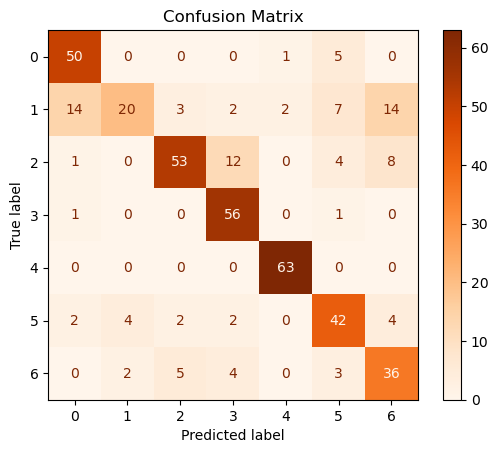

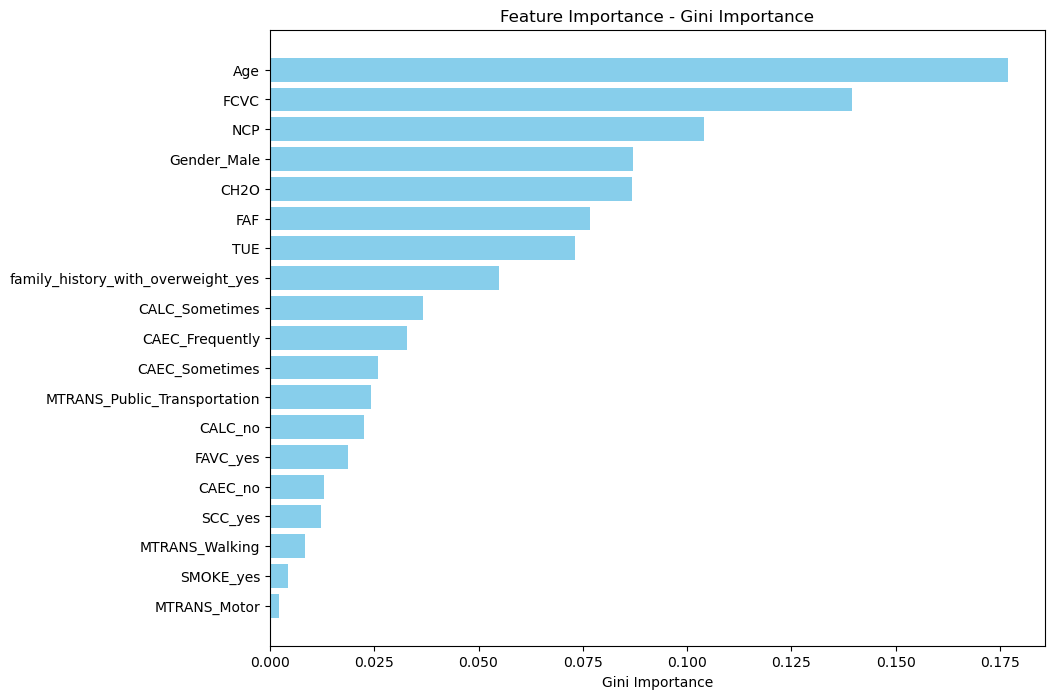

In [19]:
######################################################################################
#  Gradient Boosting Model building
######################################################################################
# creating new datasets for this analysis
x_test_gb = X_test
y_test_gb = y_test
x_train_gb = X_train
y_train_gb = y_train

## The Gradient boosting Model
gb = GradientBoostingClassifier()

# Hyperparameter search for GB.
gb_param_grid = {
    "n_estimators":[50, 100], #300
    "max_depth":[1, 3, 5],  #10   
    "learning_rate":[0.01,0.1],  # 0.5
    "subsample": [0.5,0.8],  # 1.0
    "min_samples_split": [5, 10], #2
    "max_features": ['log2', 'sqrt'],
    "min_impurity_decrease": [0.1, 0.08] # 0.3
    }

# Activate the grid search model
gb_grid_search = GridSearchCV(estimator=gb, param_grid=gb_param_grid, n_jobs = -1, cv = 5, verbose=False)


# Train the model
gb_grid_search.fit(x_train_gb, y_train_gb)

gb_best_grid = gb_grid_search.best_estimator_
gb_best_params = gb_grid_search.best_params_

######################################################################################
# Model evaluation and plotting
######################################################################################
## predicted class
y_hat_gb = gb_best_grid.predict(x_test_gb)

# Calculate the confusion matrix
cm_gb = confusion_matrix(y_test_gb, y_hat_gb)

# Calculate accuracy
accuracy_gb = accuracy_score (y_hat_gb, y_test_gb)
print(f"Accuracy: {accuracy_gb:.2f}")


# Classification Report
print("\nClassification Report:")
print(classification_report(y_test_gb, y_hat_gb))

## Confusion matrix
conf_gb = ConfusionMatrixDisplay(confusion_matrix=cm_gb)
conf_gb.plot(cmap=plt.cm.Oranges)
plt.title("Confusion Matrix")
plt.show()


## Let's get variable importance
## Getting feature names from training data
feature_names_gb = x_test_gb.columns  

## Get feature importances
importances_gb = gb_best_grid.feature_importances_

## Create a DataFrame for display
feature_imp_gb = pd.DataFrame({
    'Feature': feature_names_gb,
    'Gini Importance': importances_gb
}).sort_values('Gini Importance', ascending=False)
#print(feature_imp_gbr)

## Plot the feature importances
plt.figure(figsize=(10, 8))
plt.barh(feature_imp_gb['Feature'], feature_imp_gb['Gini Importance'], color='skyblue')
plt.xlabel('Gini Importance')
plt.title('Feature Importance - Gini Importance')
plt.gca().invert_yaxis()
plt.show()


Accuracy : 0.6241
Classification Report:
                      precision    recall  f1-score   support

Insufficient_Weight      0.558     0.768     0.647        56
      Normal_Weight      0.515     0.274     0.358        62
     Obesity_Type_I      0.632     0.615     0.623        78
    Obesity_Type_II      0.591     0.897     0.712        58
   Obesity_Type_III      0.940     1.000     0.969        63
 Overweight_Level_I      0.540     0.482     0.509        56
Overweight_Level_II      0.438     0.280     0.341        50

           accuracy                          0.624       423
          macro avg      0.602     0.617     0.594       423
       weighted avg      0.610     0.624     0.603       423



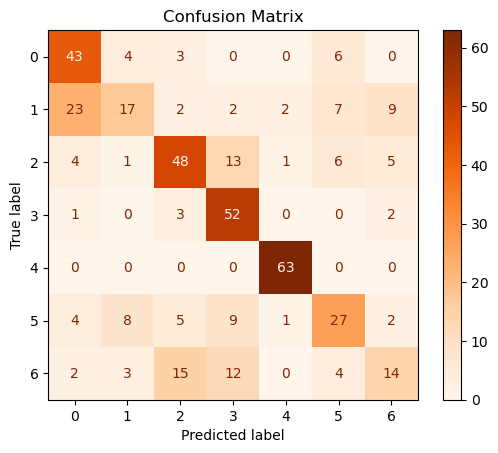

In [13]:
###########################################################################
#Lasso regression
###########################################################################
# creating new datasets for this analysis
x_test_lasso = X_test
y_test_lasso = y_test
x_train_lasso = X_train
y_train_lasso = y_train

# Fit Lasso Logistic Regression
lasso_mod = LogisticRegressionCV(
    cv=5,
    penalty='l1',  ## 'l1' fpr Lasso penalty
    solver='saga',   # there are other options
    multi_class='multinomial',
    max_iter=10000,
    random_state=42
)

# The training model
lasso_mod.fit(x_train_lasso , y_train_lasso)


# Prediction
y_hat_lasso  = lasso_mod.predict(x_test_lasso )               ## predicted class
y_proba_lasso  = lasso_mod.predict_proba(x_test_lasso )[:, 1]  ## Predicted probabilities  

# Evaluation
cm_lasso= confusion_matrix(y_test_lasso, y_hat_lasso)
accuracy_lasso= accuracy_score (y_hat_lasso, y_test_lasso)
print(f"Accuracy : {accuracy_lasso:.4f}")
print("Classification Report:\n", classification_report(y_test_lasso , y_hat_lasso , digits=3))  ## classification report

#  Confusion Matrix Plot
## Confusion matrix
conf_lasso = ConfusionMatrixDisplay(confusion_matrix=cm_lasso)
conf_lasso.plot(cmap=plt.cm.Oranges)
plt.title("Confusion Matrix")
plt.show()


Accuracy     : 0.6241
Classification Report:
                      precision    recall  f1-score   support

Insufficient_Weight      0.566     0.768     0.652        56
      Normal_Weight      0.500     0.274     0.354        62
     Obesity_Type_I      0.632     0.615     0.623        78
    Obesity_Type_II      0.591     0.897     0.712        58
   Obesity_Type_III      0.940     1.000     0.969        63
 Overweight_Level_I      0.540     0.482     0.509        56
Overweight_Level_II      0.438     0.280     0.341        50

           accuracy                          0.624       423
          macro avg      0.601     0.617     0.595       423
       weighted avg      0.609     0.624     0.603       423



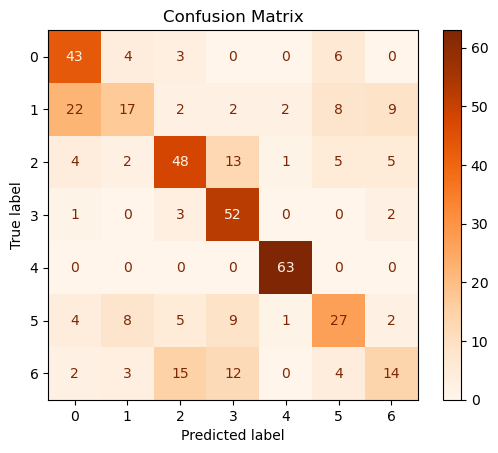

In [15]:
###########################################################################
#Ridge regression
###########################################################################
# creating new datasets for this analysis
x_test_ridge = X_test
y_test_ridge = y_test
x_train_ridge = X_train
y_train_ridge = y_train

# Fit Ridge Logistic Regression
ridge_mod = LogisticRegressionCV(
    cv=5,
    penalty='l2',  ## 'l2' for Ridge penalty
    solver='lbfgs',
    multi_class = 'multinomial',
    max_iter=50000,
    random_state=42
)

# The training model
ridge_mod.fit(x_train_ridge , y_train_ridge)

# Prediction
y_hat_ridge  = ridge_mod.predict(x_test_ridge)               ## predicted class
y_proba_ridge  = ridge_mod.predict_proba(x_test_ridge)[:, 1]  ## Predicted probabilities  


# Evaluation
cm_ridge= confusion_matrix(y_test_ridge, y_hat_ridge)
accuracy_ridge = accuracy_score(y_test_ridge, y_hat_ridge)
print(f"Accuracy     : {accuracy_ridge:.4f}")
print("Classification Report:\n", classification_report(y_test_ridge, y_hat_ridge , digits=3))

#  Confusion Matrix Plot
## Confusion matrix
conf_ridge= ConfusionMatrixDisplay(confusion_matrix=cm_ridge)
conf_ridge.plot(cmap=plt.cm.Oranges)
plt.title("Confusion Matrix")
plt.show()


Accuracy     : 0.6241
Classification Report:
                      precision    recall  f1-score   support

Insufficient_Weight      0.558     0.768     0.647        56
      Normal_Weight      0.500     0.274     0.354        62
     Obesity_Type_I      0.632     0.615     0.623        78
    Obesity_Type_II      0.591     0.897     0.712        58
   Obesity_Type_III      0.940     1.000     0.969        63
 Overweight_Level_I      0.551     0.482     0.514        56
Overweight_Level_II      0.438     0.280     0.341        50

           accuracy                          0.624       423
          macro avg      0.601     0.617     0.594       423
       weighted avg      0.609     0.624     0.603       423



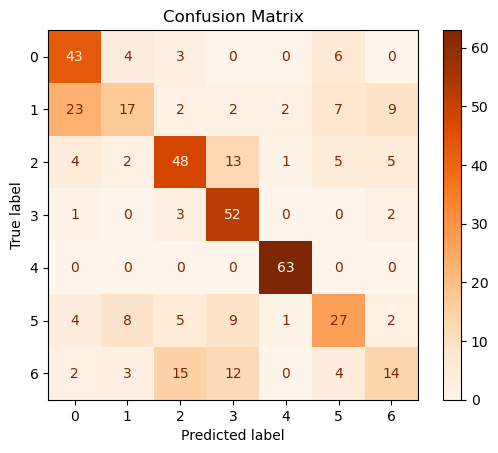

In [17]:
###########################################################################
# Elastic Net regression
###########################################################################
# creating new datasets for this analysis
x_test_enet = X_test
y_test_enet = y_test
x_train_enet = X_train
y_train_enet = y_train

# Fit ENET Logistic Regression
enet_mod = LogisticRegressionCV(
    cv=5,
    penalty='elasticnet',  ## Elastic net
    solver='saga', 
    l1_ratios=[.07, .1, .5, .7, .9],  ## list of Elastic-Net mixing parameters
    max_iter=10000,
    random_state=22
)

# The training model
enet_mod.fit(x_train_enet , y_train_enet)

# Prediction
y_hat_enet = enet_mod.predict(x_test_enet)               ## predicted class
y_proba_enet = enet_mod.predict_proba(x_test_enet)[:, 1]  ## Predicted probabilities  


# Evaluation
cm_enet= confusion_matrix(y_test_enet, y_hat_enet)
accuracy_enet = accuracy_score(y_test_enet, y_hat_enet)
print(f"Accuracy     : {accuracy_enet:.4f}")
print("Classification Report:\n", classification_report(y_test_enet, y_hat_enet, digits=3))


#  Confusion Matrix Plot
## Confusion matrix
conf_enet= ConfusionMatrixDisplay(confusion_matrix=cm_enet)
conf_enet.plot(cmap=plt.cm.Oranges)
plt.title("Confusion Matrix")
plt.show()

{0: 'Insufficient_Weight', 1: 'Normal_Weight', 2: 'Obesity_Type_I', 3: 'Obesity_Type_II', 4: 'Obesity_Type_III', 5: 'Overweight_Level_I', 6: 'Overweight_Level_II'}
The dependent (Y) dataset has (2111,).
The independent (X) dataset has (2111, 19).
The training dataset has 1688 observations
The test dataset has 423 observations
The training dataset has (1688, 19)
The test dataset has (423, 19)
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Accuracy     : 0.8085

Classification Report:
              precision    recall  f1-score   support

         0.0       0.84      0.91      0.87        56
         1.0       0.65      0.58      0.62        62
         2.0       0.83      0.82      0.83        78
         3.0       0.82      0.97      0.89        58
         4.0       0.97      1.00      0.98        63
         5.0       0.74      0.71      0.73        56
         6.0       0.74      0.64      0.69        50

    accuracy                           0.81       423
   macro a

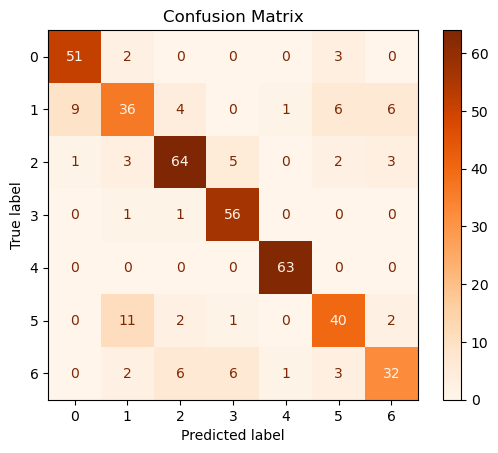

In [23]:
#############################################################
## Support Vector Machine (SVC)    
#############################################################
# seed for reproducibility
seed = 555

## The below is necessary for starting Numpy generated random numbers
## in a well-defined initial state.
np.random.seed(seed)

# Train (80%) and test (20%) set split (For the contregress)
# Make separate data set for Y and X
Y_bin = dat_encoded['NObeyesdad']
X_bin = dat_encoded.drop(['NObeyesdad'], axis=1)

## Recoding the Y_bin into float 0.0 to 6.0
# Define the categorical type with ordered unique categories
cat_type = CategoricalDtype(categories=sorted(Y_bin.unique()), ordered=True)

# Applying the encoding
Y_bin = Y_bin.astype(cat_type).cat.codes.astype(float)

# Optional: Check the mapping
label_mapping = dict(enumerate(cat_type.categories))
print(label_mapping)
print(f'The dependent (Y) dataset has {Y_bin.shape}.')
print(f'The independent (X) dataset has {X_bin.shape}.')

# Splitting the dataset into train and test sets
X_train, X_test, y_train, y_test  = train_test_split( X_bin, Y_bin, test_size = 0.2, random_state = 42)
print(f'The training dataset has {len(X_train)} observations')
print(f'The test dataset has {len(X_test)} observations')

# Standardization of continuous variable.
# VERY IMPORTANT: To avoid any information leaking from testing data to training data, we do standardization separately. 
# define continuous variable columns
final_cont_vars = ['Age','FCVC','CH2O','FAF', 'NCP', 'TUE']
scaler = StandardScaler()
X_train[continuous_vars] = scaler.fit_transform(X_train[continuous_vars])
X_test[continuous_vars] = scaler.fit_transform(X_test[continuous_vars])
#print(X_train[continuous_vars].describe())
#print(X_test[continuous_vars].describe())

## checking the dimension of data
print(f'The training dataset has {X_train.shape}')
print(f'The test dataset has {X_test.shape}')

# creating new datasets for this analysis
x_test_svc = X_test
y_test_svc = y_test
x_train_svc = X_train
y_train_svc = y_train

# SVC
svc = SVC(probability = True, 
          decision_function_shape = 'ovr',
          random_state = 42)

# Parameter grid
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf'],
    'gamma': ['scale', 0.01, 0.1, 1]
}

seed = 42
cv = KFold(n_splits=5, shuffle=True, random_state = seed)

# Grid search with reproducible splits
grid_search = GridSearchCV(
    estimator=svc,
    param_grid=param_grid,
    cv=cv,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

# The training model
svc_cv = grid_search.fit(x_train_svc, y_train_svc)

###########################################################################
#Test Set Evaluation
###########################################################################
best_svc = svc_cv.best_estimator_
y_hat_svc = best_svc.predict(x_test_svc)

## confusion matrix
cm_svc = confusion_matrix(y_test_svc, y_hat_svc)
accuracy_svc = accuracy_score(y_hat_svc, y_test_svc)
print(f"Accuracy     : {accuracy_svc:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test_svc, y_hat_svc))

#  Confusion Matrix Plot
## Confusion matrix
conf_svc = ConfusionMatrixDisplay(confusion_matrix=cm_svc)
conf_svc.plot(cmap=plt.cm.Oranges)
plt.title("Confusion Matrix")
plt.show()


                 Model  Accuracy
0  Logistic Regression  0.617021
1                Lasso  0.624113
2                Ridge  0.624113
3           ElasticNet  0.624113
4        Decision Tree  0.676123
5        Random Forest  0.813239
6    Gradient Boosting  0.756501
7                  SVC  0.808511


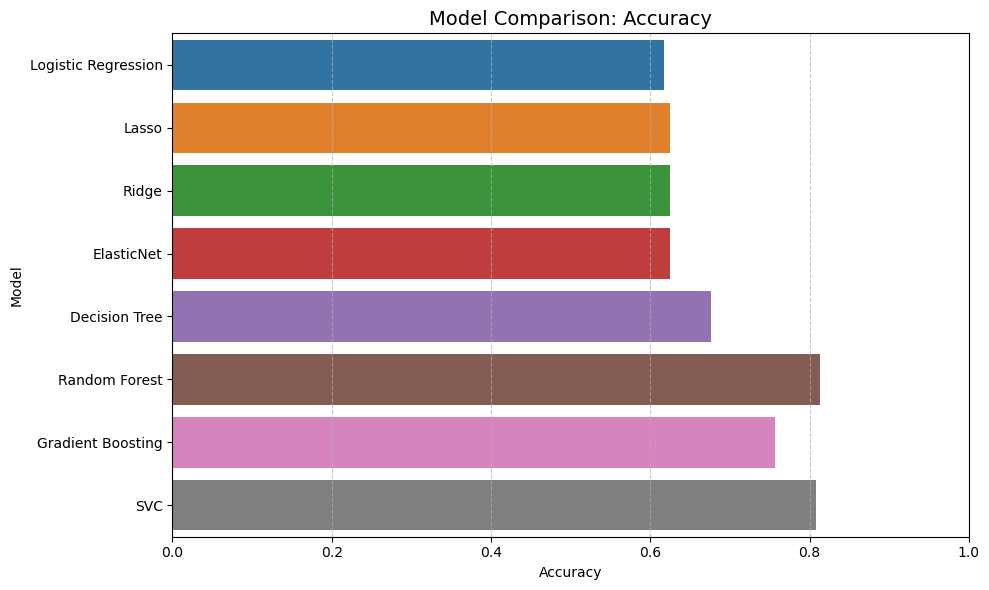

In [38]:
################################################################
## Plotting the R2_score for all the models and choose the best
################################################################

model_names = ['Logistic Regression', 'Lasso', 'Ridge', 'ElasticNet', 'Decision Tree',
               'Random Forest', 'Gradient Boosting', 'SVC']

accuracy = [accuracy_mult, accuracy_lasso, accuracy_ridge, accuracy_enet, accuracy_dt, 
            accuracy_rf, accuracy_gb, accuracy_svc]


# Build long-form dataframe
metrics_df = pd.DataFrame({
    'Model': model_names ,
    'Accuracy': accuracy        
})
print(metrics_df)

# Plot grouped bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_df, x='Accuracy', y='Model')
plt.title('Model Comparison: Accuracy', fontsize=14)
plt.xlabel('Accuracy')
plt.xlim(0, 1)
plt.ylabel('Model')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('comparing the performance of the models.png')
plt.show()
